In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle datasets download -d gauravduttakiit/new-york-taxi
!kaggle datasets download -d mlg-ulb/creditcardfraud

In [ ]:
# Unzip Dataset.
!unzip new-york-taxi.zip
!unzip creditcardfraud.zip

# **New York City Taxi Fare Prediction**

Predict a rider's taxi fare?

> [**Kaggle Dataset**](https://www.kaggle.com/datasets/gauravduttakiit/new-york-taxi)

In [8]:
# Import Library.
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from sklearn.ensemble import IsolationForest

mpl.rcParams["figure.figsize"] = (7, 4)
mpl.rcParams["axes.grid"] = False

import warnings

warnings.filterwarnings("ignore")

In [9]:
# Load Dataset.
data = pd.read_csv("nyc_taxi.csv")
data.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [10]:
# Feature Engineering.
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp").resample("H").mean().reset_index()

data["hour"] = data.timestamp.dt.hour

data["weekday"] = pd.Categorical(
    data.timestamp.dt.strftime("%A"),
    categories=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    ordered=True,
)

data["day"] = data.timestamp.dt.weekday

data.head()

,timestamp,value,hour,weekday,day
0,2014-07-01 00:00:00,9485.5,0,Tuesday,1
1,2014-07-01 01:00:00,5433.0,1,Tuesday,1
2,2014-07-01 02:00:00,3346.5,2,Tuesday,1
3,2014-07-01 03:00:00,2216.5,3,Tuesday,1
4,2014-07-01 04:00:00,2189.5,4,Tuesday,1


In [ ]:
# Plot Time Series Data.
fig = px.line(data.reset_index(), x="timestamp", y="value", title="NYC Taxi Demand")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

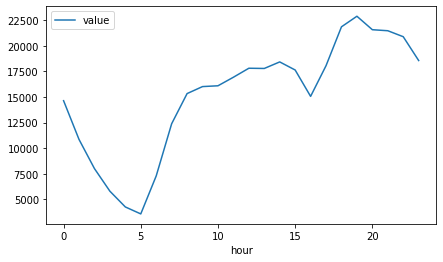

In [12]:
data[["value", "hour"]].groupby("hour").mean().plot()

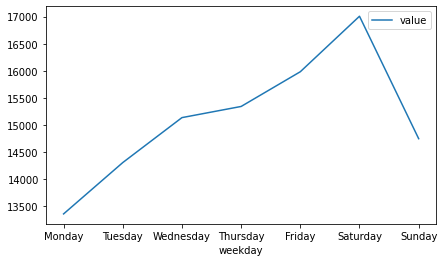

In [13]:
data[["value", "weekday"]].groupby("weekday").mean().plot()

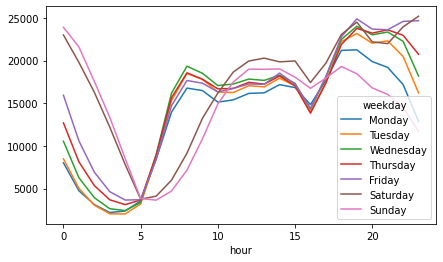

In [14]:
data.groupby(["hour", "weekday"]).mean()["value"].unstack().plot()

In [15]:
data = data.join(
    data.groupby(["hour", "weekday"])["value"].mean(),
    on=["hour", "weekday"],
    rsuffix="_avg",
)
data.head()

,timestamp,value,hour,weekday,day,value_avg
0,2014-07-01 00:00:00,9485.5,0,Tuesday,1,8483.709677
1,2014-07-01 01:00:00,5433.0,1,Tuesday,1,5028.193548
2,2014-07-01 02:00:00,3346.5,2,Tuesday,1,3052.112903
3,2014-07-01 03:00:00,2216.5,3,Tuesday,1,2039.580645
4,2014-07-01 04:00:00,2189.5,4,Tuesday,1,2031.258065


In [16]:
data.set_index("timestamp").loc["2014-11-02"].head()

,value,hour,weekday,day,value_avg
timestamp,,,,,
2014-11-02 00:00:00,24109.5,0,Sunday,6,23898.733333
2014-11-02 01:00:00,37204.5,1,Sunday,6,21593.533333
2014-11-02 02:00:00,12754.5,2,Sunday,6,17555.266667
2014-11-02 03:00:00,8955.5,3,Sunday,6,13350.550000
2014-11-02 04:00:00,5453.5,4,Sunday,6,8506.500000


In [17]:
data.set_index("timestamp").loc["2015-01-26":"2015-01-27"].head()

,value,hour,weekday,day,value_avg
timestamp,,,,,
2015-01-26 00:00:00,5907.0,0,Monday,0,8020.283333
2015-01-26 01:00:00,3649.5,1,Monday,0,4749.750000
2015-01-26 02:00:00,2310.0,2,Monday,0,3125.800000
2015-01-26 03:00:00,1949.5,3,Monday,0,2195.133333
2015-01-26 04:00:00,2165.5,4,Monday,0,2373.166667


# **Anomaly Detection**

> [**Anomaly Detection - Wikipedia**](https://en.wikipedia.org/wiki/Anomaly_detection)

> [**Novelty and Outlier Detection - Sklearn**](https://scikit-learn.org/stable/modules/outlier_detection.html)

In data analysis, anomaly detection (also outlier detection) is the identification of rare items, events, or observations that raise suspicions by differing significantly from the majority of the data. Typically the anomalous items will translate to some kind of problems such as bank fraud, a structural defect, medical problems, or errors in a text. Anomalies are also referred to as outliers, novelties, noise, deviations, and exceptions.

Anomaly Detection is applicable in different domains, such as intrusion detection, fraud detection, fault detection, system health monitoring, event detection in sensor networks, detecting ecosystem disturbances, and defect detection in images using machine vision. It is often used in preprocessing to remove anomalous data from the dataset. In supervised learning, removing the anomalous data from the dataset often results in a statistically significant and therefore increase in accuracy.

**Three broad categories of anomaly detection techniques exist:**

*   **Unsupervised Anomaly Detection** techniques detect anomalies in an unlabeled test dataset under the assumption that the majority of the instances in the dataset are normal by looking for instances that seem to fit least to the remainder of the dataset.

*   **Supervised Anomaly Detection** techniques require a dataset that has been labeled as "normal" and "abnormal" and involves training a classifier (the key difference to many other statistical classification problems is the inherently unbalanced nature of outlier detection).

*   **Semi-supervised Anomaly Detection** techniques construct a model representing normal behavior from a given normal training dataset and then test the likelihood of a test instance to be generated by the utilized model.

In [18]:
""" Z-Score Formula: Z = (X - Mean) / Std. """

# Handling Outliers with Z-Score.
def ztransform_outliers(array, threshold):
    outliers = []
    z_score = stats.zscore(array)
    for i in range(len(z_score)):
        if z_score[i] > threshold or z_score[i] < -threshold:
            outliers.append(int((z_score[i] * np.std(array)) + np.mean(array)))
    new_array = [i for i in array if i not in outliers]
    return np.sort(outliers), np.sort(new_array)


""" Steps to calculate InterQuantile Range. """

# Step 1: Sort the data values in ascending order.
# Step 2: Calculate the first Quartile and the third Quartile values.
# Step 3: Find InterQuantile Range value, i.e., (Q3 - Q1).
# Step 4: Find Lower Bound value, i.e., (Q1 * 1.5).
# Step 5: Find Upper Bound value, i.e., (Q3 * 1.5).
# Anything that lies outside of lower and upper bound is an outlier.


# Handling Outliers with InterQuartile Range (IQR).
def iqr_outliers(array):
    quartile1, quartile3 = np.percentile(array, [25, 75])
    iqr_value = quartile3 - quartile1  # stats.iqr(data, rng = (25, 75))
    lower_bound_val = quartile1 - (1.5 * iqr_value)
    upper_bound_val = quartile3 + (1.5 * iqr_value)
    outliers = []
    for i in range(len(array)):
        if array[i] > upper_bound_val or array[i] < lower_bound_val:
            outliers.append(array[i])
    new_array = [i for i in array if i not in outliers]
    return np.sort(outliers), np.sort(new_array)

# **Isolation Forest**

***Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms.***

Isolation Forest [[Wikipedia]](https://en.wikipedia.org/wiki/Isolation_forest) [[Paper]](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) is a machine learning algorithm for anomaly detection. It is an unsupervised learning algorithm that identifies anomalies by isolating outliers in the data. Isolation Forest is based on the Decision Tree algorithm. This algorithm isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the "max" and "min" values of that feature. This random partitioning of features produces shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

In general, the first step to anomaly detection is to construct a profile of what's "normal", and then report anything that cannot be considered normal, as anomalous. However, the isolation forest algorithm does not work on this principle. This algorithm does not first define "normal" behavior, and it does not calculate point-based distances. As we might expect from the name, Isolation Forest instead works by isolating anomalies explicitly by isolating the anomalous points in the dataset.

Isolation Forest isolates anomalies in the data points instead of profiling normal data points. As anomalies data points mostly have a lot shorter tree paths than the normal data points, trees in the isolation forest do not need to have a large depth, so a smaller max_depth can be used resulting in low memory requirement.

> [**sklearn.ensemble.IsolationForest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

> [**Isolation Forest - H2O.ai**](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html)


In [19]:
# Feature Selection.
df = data[["value", "hour", "day"]]

# Isolation Forest Model Training.
model = IsolationForest(
    contamination=0.005, max_features=3, max_samples=0.8, n_estimators=200
)
model.fit(df)

# Predict Outliers.
data["outliers"] = pd.Series(model.predict(df)).apply(
    lambda x: "Yes" if (x == -1) else "No"
)
data.head()

,timestamp,value,hour,weekday,day,value_avg,outliers
0,2014-07-01 00:00:00,9485.5,0,Tuesday,1,8483.709677,No
1,2014-07-01 01:00:00,5433.0,1,Tuesday,1,5028.193548,No
2,2014-07-01 02:00:00,3346.5,2,Tuesday,1,3052.112903,No
3,2014-07-01 03:00:00,2216.5,3,Tuesday,1,2039.580645,No
4,2014-07-01 04:00:00,2189.5,4,Tuesday,1,2031.258065,No


In [20]:
# Count of Outliers.
data["outliers"].value_counts()

No     5134
Yes      26
Name: outliers, dtype: int64

In [ ]:
# Plot Anomaly in Time Series Data.
fig = px.scatter(
    data,
    x="timestamp",
    y="value",
    color="outliers",
    hover_data=["weekday", "hour", "value_avg"],
    title="NYC Taxi Demand",
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   3.,   1.,   3.,   2.,   1.,   4.,   4.,   4.,   3.,   8.,
         14.,  20.,  17.,  22.,  22.,  38.,  41.,  48.,  84.,  81., 113.,
        105., 147., 177., 201., 247., 259., 338., 400., 426., 423., 434.,
        368., 262., 307., 235., 219.,  74.]),
 array([-0.13173771, -0.12502551, -0.11831331, -0.1116011 , -0.1048889 ,
        -0.0981767 , -0.09146449, -0.08475229, -0.07804008, -0.07132788,
        -0.06461568, -0.05790347, -0.05119127, -0.04447907, -0.03776686,
        -0.03105466, -0.02434245, -0.01763025, -0.01091805, -0.00420584,
         0.00250636,  0.00921857,  0.01593077,  0.02264297,  0.02935518,
         0.03606738,  0.04277958,  0.04949179,  0.05620399,  0.0629162 ,
         0.0696284 ,  0.0763406 ,  0.08305281,  0.08976501,  0.09647721,
         0.10318942,  0.10990162,  0.11661383,  0.12332603,  0.13003823,
         0.13675044,  0.14346264,  0.15017484,  0.15688705,  0.16359925,
 

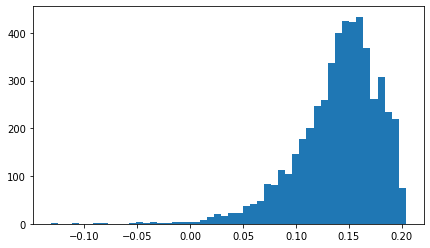

In [22]:
score = model.decision_function(df)
plt.hist(score, bins=50)

In [23]:
data["scores"] = score
data.head()

,timestamp,value,hour,weekday,day,value_avg,outliers,scores
0,2014-07-01 00:00:00,9485.5,0,Tuesday,1,8483.709677,No,0.100295
1,2014-07-01 01:00:00,5433.0,1,Tuesday,1,5028.193548,No,0.147874
2,2014-07-01 02:00:00,3346.5,2,Tuesday,1,3052.112903,No,0.162252
3,2014-07-01 03:00:00,2216.5,3,Tuesday,1,2039.580645,No,0.173253
4,2014-07-01 04:00:00,2189.5,4,Tuesday,1,2031.258065,No,0.178950


# **Credit Card Fraud Detection**

Anonymized credit card transactions labeled as fraudulent or genuine.

> [**Kaggle Dataset**](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In this project, we will build the following two machine learning algorithms for outlier detection.

*   Local Outlier Factor (LOF) [**[Website]**](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html) [**[Wikipedia]**](https://en.wikipedia.org/wiki/Local_outlier_factor)

*   Isolation Forest Algorithm [**[Website]**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) [**[Wikipedia]**](https://en.wikipedia.org/wiki/Isolation_forest)

In [24]:
# Load Dataset.
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [25]:
# Drop Missing Features.
data = data.dropna()

In [26]:
print("The shape of the dataset is", data.shape)

The shape of the dataset is (284807, 31)


In [27]:
print("List of columns in the dataset are: \n", data.columns)

List of columns in the dataset are: 
 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [28]:
# Determine the number of fraud transactions in the dataset.
Fraud = data[data["Class"] == 1]
Valid = data[data["Class"] == 0]

outlier_fraction = len(Fraud) / float(len(Valid))
print(outlier_fraction)

print("Fraud Transactions: {}".format(len(data[data["Class"] == 1])))
print("Valid Transactions: {}".format(len(data[data["Class"] == 0])))

0.0017304750013189597
Fraud Transactions: 492
Valid Transactions: 284315


In [29]:
# Split Dataset into Feature and Target Set.
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

## **Unsupervised Outlier Detection**

#### **1. Local Outlier Factor (LOF)**

Local Outlier Factor (LOF) is an algorithm used for unsupervised outlier detection. It produces an anomaly score that represents data points that are outliers in the dataset. It does this by measuring the local density deviation of a given data point with respect to the data points near it.

Local density is determined by estimating the distances between data points that are neighbors (K-nearest neighbors). So for each data point, local density can be calculated. By comparing these, we can check which data points have similar densities and which data points have a lesser density than their neighbors. The ones with the lesser densities are considered as the outliers. Firstly, K-distances are distances between points that are calculated for each point to determine their K-nearest neighbors. The 2nd closest point is the 2nd nearest neighbor to the point.

#### **2. Isolation Forest Algorithm**

Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest, like any tree ensemble method, is built based on decision trees. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning, they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.

In [30]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report

classifier = {
    "isolation_forest": IsolationForest(
        max_samples=len(X), contamination=outlier_fraction, random_state=1
    ),
    "local_outlierfactor": LocalOutlierFactor(
        n_neighbors=21, contamination=outlier_fraction, novelty=True
    ),
}

plt.figure(figsize=(7, 4))
n_outliers = len(Fraud)

for i, (clf_name, clf) in enumerate(classifier.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)

    # Reshape the prediction values to 0 for valid and 1 for fraud.
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()

    # Run Classification Metrics.
    print("{}: {}".format(clf_name, n_errors))
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred))

isolation_forest: 647
0.9977282861727416
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.34      0.34      0.34       492

    accuracy                           1.00    284807
   macro avg       0.67      0.67      0.67    284807
weighted avg       1.00      1.00      1.00    284807

local_outlierfactor: 846
0.9970295673912509
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.06      0.04      0.05       492

    accuracy                           1.00    284807
   macro avg       0.53      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



<Figure size 504x288 with 0 Axes>

# **PyCaret Anomaly Detection**

![image.png](https://raw.githubusercontent.com/pycaret/pycaret/master/docs/images/logo.png)

#### **PyOD Library:** *PyOD is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data*.

> [**Welcome to PyOD Documentation!**](https://pyod.readthedocs.io/en/latest/#)

> [**PyCaret Anomaly Detection - Documentation**](https://pycaret.org/anomaly-detection/)

In [ ]:
!pip install pycaret
!pip install markupsafe==2.0.1

In [1]:
# Import the Dataset from the PyCaret Repository.
from pycaret.datasets import get_data

anomaly = get_data("anomaly")
print("Dataset Shape: ", anomaly.shape)

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754


Dataset Shape:  (1000, 10)


In [2]:
# Import anomaly detection module.
from pycaret.anomaly import *

# Intialize the Setup.
exp_ano = setup(
    anomaly, session_id=1997, log_experiment=True, experiment_name="anomaly-detection"
)

,Description,Value
0,session_id,1997
1,Original Data,"(1000, 10)"
2,Missing Values,False
3,Numeric Features,10
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(1000, 10)"
9,CPU Jobs,-1


2022/07/19 17:31:16 INFO mlflow.tracking.fluent: Experiment with name 'anomaly-detection' does not exist. Creating a new experiment.


In [ ]:
# Create a Model.
iforest = create_model("iforest")

# Plot a Model.
plot_model(iforest)

In [ ]:
# Create a Model.
knn = create_model("knn")

# Plot a Model.
plot_model(knn)

In [5]:
# Generate predictions using the trained model.
knn_predictions = predict_model(knn, data=anomaly)
knn_predictions

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Anomaly,Anomaly_Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,0,0.558927
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,0.477482
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,0,0.676207
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,0.804769
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,0.630836
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.305055,0.656837,0.331665,0.822525,0.907127,0.882276,0.855732,0.584786,0.808640,0.242762,0,0.266822
996,0.812627,0.864258,0.616604,0.167966,0.811223,0.938071,0.418462,0.472306,0.348347,0.671129,0,0.403480
997,0.250967,0.138627,0.919703,0.461234,0.886555,0.869888,0.800908,0.530324,0.779433,0.234952,0,0.337727
998,0.502436,0.936820,0.580062,0.540773,0.151995,0.059452,0.225220,0.242755,0.279385,0.538755,0,0.300265


In [6]:
# Alternative: Generate predictions using the trained model.
knn_results = assign_model(knn)
knn_results

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Anomaly,Anomaly_Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,0,0.569672
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,0.484217
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,1,0.691915
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,0.811600
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,0.634337
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.305055,0.656837,0.331665,0.822525,0.907127,0.882276,0.855732,0.584786,0.808640,0.242762,0,0.294537
996,0.812627,0.864258,0.616604,0.167966,0.811223,0.938071,0.418462,0.472306,0.348347,0.671129,0,0.414982
997,0.250967,0.138627,0.919703,0.461234,0.886555,0.869888,0.800908,0.530324,0.779433,0.234952,0,0.361396
998,0.502436,0.936820,0.580062,0.540773,0.151995,0.059452,0.225220,0.242755,0.279385,0.538755,0,0.337370


In [7]:
# Save the trained Model.
save_model(knn, model_name="knn")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                 ('fix_perfect', 'passthrough'),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  KNN

In [8]:
# Load the trained Model.
from pycaret.anomaly import load_model, predict_model

load_knn = load_model("knn")
predict_knn = predict_model(load_knn, data=anomaly)
predict_knn.head()

Transformation Pipeline and Model Successfully Loaded


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Anomaly,Anomaly_Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,0,0.558927
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,0.477482
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,0,0.676207
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,0.804769
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,0.630836
